# Keyword Extraction


## What is Keyword Extraction?


**Keyword Extraction** is a task of choosing keywords from a text/document. Here, **keywords** are words or sequences of one or more words which provide a compact describsion of a text's content.  

Keywords are widely use in information retrieval(IR) systems as they are simple to revise and remember. They can be used to enrich the presentation of search results as well.

## How to Extract Keywords?

Main processes in keyword extraction are:


1.   Generating candidate keywords
2.   Defining and Calculating scores of candidates
3.   Ranking cadidate keywords and sorting in descending order. 
4.   Selecting top k candidates as the k keywords


There are many approaches in this extraction task due to Definitions of scores of cadidates and Calculation Methods. In this article we introduce two popular methods:



1.   TF-IDF based method
2.   RAKE: Rapid Automatic Keyword Extraction

We will explore these methods with example of keyword extraction from real dataset of scientific research papers' abtracts in the following parts.



## Downdload dataset: [Inspec](https://dl.acm.org/doi/10.3115/1119355.1119383)

Inspec consists of 2,000 abstracts of scientific journal papers from Computer Science collected between the years 1998 and 2002. Each document has two sets of keywords assigned: the controlled keywords, which are manually controlled assigned keywords that appear in the Inspec thesaurus but may not appear in the document, and the uncontrolled keywords which are freely assigned by the editors, i.e., are not restricted to the thesaurus or to the document. In our repository, we consider a union of both sets as the ground-truth .[[Download source]](https://github.com/LIAAD/KeywordExtractor-Datasets#inspec)

!wget https://github.com/LIAAD/KeywordExtractor-Datasets/raw/master/datasets/Inspec.zip

!unzip -q Inspec.zip

In [1]:
from os import listdir

docsPaths = listdir('Inspec/docsutf8')
data = []
for p in docsPaths:
  textPath = 'Inspec/docsutf8/'+p
  keyPath = 'Inspec/keys/'+p[:-3]+'key'
  with open(textPath) as fi:
    text = fi.read()
  with open(keyPath) as fi:
    key = fi.read()
  data.append({'text':text, 'key':key})
print("make data: DONE")

FileNotFoundError: [Errno 2] No such file or directory: 'Inspec/docsutf8'

In [4]:
print("Total number of texts in the dataset:",len(data))
print("data[1000]:\n\n",data[1000]['text'])
print("\n\nkeywords:\n")
for i in data[1000]['key'].replace('\t','').split("\n"):
  print(i)

Total number of texts in the dataset: 2000
data[1000]:

 The development of a mobile manipulator imaging system for bridge crack
	inspection
A mobile manipulator imaging system is developed for the automation of bridge
	crack inspection. During bridge safety inspections, an eyesight
	inspection is made for preliminary evaluation and screening before a
	more precise inspection. The inspection for cracks is an important part
	of the preliminary evaluation. Currently, the inspectors must stand on
	the platform of a bridge inspection vehicle or a temporarily erected
	scaffolding to examine the underside of a bridge. However, such a
	procedure is risky. To help automate the bridge crack inspection
	process, we installed two CCD cameras and a four-axis manipulator
	system on a mobile vehicle. The parallel cameras are used to detect
	cracks. The manipulator system is equipped with binocular charge
	coupled devices (CCD) for examining structures that may not be
	accessible to the eye. The syst

## Text Preprocessing


In text preprocessing we : 

*   convert to lowercase
*   remove tages
*   remove special characters and digits
*   remove [stopwords](https://en.wikipedia.org/wiki/Stop_word)

In [5]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
stopwords_set = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
def preprocess(input_text):
    input_text = input_text.lower()
    input_text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", input_text)
    input_text = re.sub("(\\d|\\W)+"," ", input_text)
    text_string = input_text.split()
    text_string = [word for word in text_string if word not in stopwords_set]
    lemmatizer = WordNetLemmatizer()
    text_string = [lemmatizer.lemmatize(word) for word in text_string]
    return ' '.join(text_string)

In [7]:
docs = [preprocess(x['text']) for x in data]
keys = [x['key'].replace('\t','').split('\n')[:-1] for x in data]
print(len(docs),len(keys))

2000 2000


## TF-IDF based method

In this method, each word in text(tokenized string list) is consider as a candidate. Score of cadidate keyword is define by [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) score. The k candidate keywords with the highest TF-IDF score are selected as keywords.

TF-IDF(term frequency–inverse document frequency) is a numerical statistic which reflect the importance of word in a text while considering it occurence within a group of documents(corpus).

Consider a corpus with $N$ documents. Let $t_{i,j}$ be frequency of term $w_i (i=1,\cdots,W)$ in document $D_j$ and $df_i$ be number of documents which term $w_i$ occurences in. TF-IDF score of term $w_i$ is defined by $\operatorname{tfidf}(i)$.

$$
\operatorname{tfidf}(i) = \sum_{j=1}^{N} t_{i,j}\log{\frac{N}{df_i}}
$$

In the following implimentation, we use tools offered by *scikitlearn*.

[CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn-feature-extraction-text-countvectorizer)     
[TfidfTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html)



In [8]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [9]:
vectorizer = CountVectorizer(max_df=0.95, max_features=20000, ngram_range=(1,4))
word_freq_vec = vectorizer.fit_transform(docs)
transformer = TfidfTransformer(smooth_idf=True, use_idf=True)
transformer.fit(word_freq_vec)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [10]:
def extract_topk(features, sorted_words, k=10):
    sorted_words = sorted_words[:k]
    scores = []
    f_list = []
    for i, score in sorted_words:
        scores.append(round(score, 3))
        f_list.append(features[i])
    result = {}
    for i in range(len(f_list)):
        result[f_list[i]] = scores[i]
    return result

def get_keywords(idx, docs):
    tfidf_vec = transformer.transform(vectorizer.transform([docs[idx]]))
    co_matrix = tfidf_vec.tocoo()
    sorted_words = sorted(zip(co_matrix.col, co_matrix.data), key=lambda x: (x[1],x[0]), reverse=True)
    features = vectorizer.get_feature_names()
    keywords = extract_topk(features, sorted_words, 10)
    return keywords

def print_keywords(idx, keywords, data, ans):
    ans = [preprocess(a) for a in ans[:len(keywords)]]
    print("\n=====Abstract=====")
    print(data[idx]['text'])
    print("\n===Keywords===")
    for k in keywords:
        if k in ans:
          print("🟢",end='')
        print(k,keywords[k])
    print("\n===Keywords by Author===")
    ext_keys = [i for i in keywords]
    for i in ans:
      if i in ext_keys:
          print("🙆‍♂️",end="")
      print(i)

In [11]:
sample_idx = 10
keywords=get_keywords(sample_idx, docs)
print_keywords(sample_idx,keywords, data, keys[sample_idx])


=====Abstract=====
Fractional differentiation in passive vibration control
From a single-degree-of-freedom model used to illustrate the concept of
	vibration isolation, a method to transform the design for a suspension
	into a design for a robust controller is presented. Fractional
	differentiation is used to model the viscoelastic behaviour of the
	suspension. The use of fractional differentiation not only permits
	optimisation of just four suspension parameters, showing the
	'compactness' of the fractional derivative operator, but also leads to
	robustness of the suspension's performance to uncertainty of the sprung
	mass. As an example, an engine suspension is studied


===Keywords===
🟢suspension 0.537
fractional 0.353
🟢fractional differentiation 0.341
🟢differentiation 0.289
vibration 0.164
🟢vibration isolation 0.118
use fractional 0.118
single degree freedom 0.118
single degree 0.118
operator also 0.118

===Keywords by Author===
🙆‍♂️fractional differentiation
passive vibration con

With this method, four of extracted top ten keywords are in keywords set selected by author. This result is somehow acceptable. However, to calculate TF-IDF score, a collection of documents(corpus) is required as reference data. Therefore, characteristic of reference data(corpus) highly affect the importance of word in single document. Keywords that occur in many documents within the corpus are not likely to be selected as statistically discriminating by lowering the TF-IDF score value.

## RAKE: Rapid Automatic Keyword Extraction

*(Ref: Rose, Stuart & Engel, Dave & Cramer, Nick & Cowley, Wendy. (2010). [Automatic Keyword Extraction from Individual Documents](https://www.researchgate.net/publication/227988510_Automatic_Keyword_Extraction_from_Individual_Documents). 10.1002/9780470689646.ch1.)*



RAKE is a keyword extraction method which is effectively operates on individual document. RAKE is based on an observation that keywords frequently contain multiple
words but rarely contain standard punctuation or stop words.

RAKE get a list of stop words, a
set of phrase delimiters, and a set of word delimiters as inputs. Base on the information from stop words and
phrase delimiters, RAKE makes partitions of the document text into candidate keywords. 

Next, co-occurrences graph of words
within these candidate keywords are generated. This graph is significient in identifying word cooccurrence without the application of an arbitrarily sized sliding window. 

Several metrics are used for calculating word scores

1.   word frequency : $freq(w)$
2.   word degree : $deg(w)$
3.   ratio of degree to frequency : $\frac{deg(w)}{freq(w)}$

In summary, $deg(w)$ favors words that occur often and in
longer candidate keywords. Words
that occur frequently regardless of the number of words with which they co-occur
are favored by $freq(w)$. Words that
predominantly occur in longer candidate keywords are favored by $deg(w)/freq(w)$ [[Ref]](https://www.researchgate.net/publication/227988510_Automatic_Keyword_Extraction_from_Individual_Documents).

The score for each candidate keyword is computed as the sum of its member word scores.


**Example of score calculation from  [Automatic Keyword Extraction from Individual Documents](https://www.researchgate.net/publication/227988510_Automatic_Keyword_Extraction_from_Individual_Documents)**




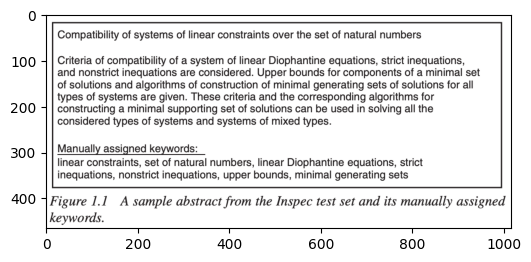

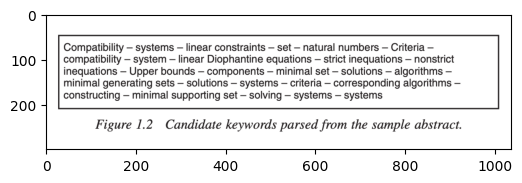

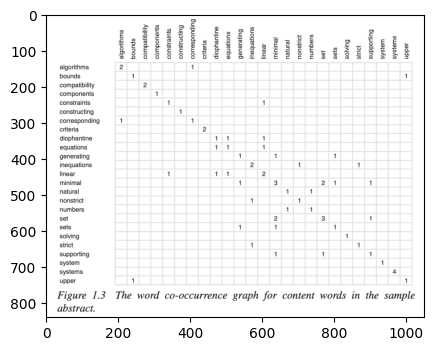

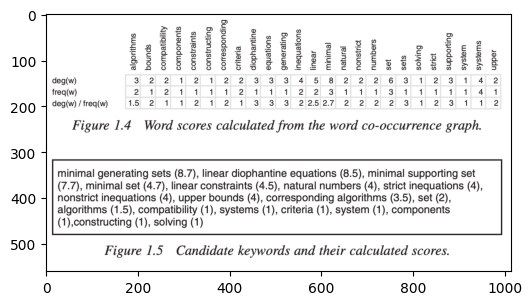

In [12]:
import matplotlib.pyplot as plt
from PIL import Image

for f in ['fig01.png','fig02.png','fig03.png','fig04.png',]:
  fig, ax = plt.subplots(dpi=100)
  img = Image.open(f)
  ax.imshow(img)
  plt.show()

In [13]:
!pip install rake-nltk

In [14]:
from rake_nltk import Rake

In [15]:
def get_keywords_rake(docs, n=10):
    rk = Rake()
    rk.extract_keywords_from_text(docs)
    keywords = rk.get_ranked_phrases_with_scores()[0:n]
    return keywords

def print_keywords_rake(idx, keywords, data, ans):
    ans = [preprocess(a) for a in ans[:len(keywords)]]
    print("\n=====Abstract=====")
    print(data[idx]['text'])
    print("\n===Keywords===")
    for k in keywords:
        if k[1] in ans:
          print("🟢",end="")
        print(k[1],k[0])
    print("\n===Keywords by Author===")
    ext_keys = [i[1] for i in keywords]
    for i in ans:
      if i in ext_keys:
          print("🙆‍♂️",end="")
      print(i)

In [16]:
sample_idx = 10 
keywords=get_keywords_rake(data[sample_idx]['text'])
print_keywords_rake(sample_idx,keywords, data, keys[sample_idx])



=====Abstract=====
Fractional differentiation in passive vibration control
From a single-degree-of-freedom model used to illustrate the concept of
	vibration isolation, a method to transform the design for a suspension
	into a design for a robust controller is presented. Fractional
	differentiation is used to model the viscoelastic behaviour of the
	suspension. The use of fractional differentiation not only permits
	optimisation of just four suspension parameters, showing the
	'compactness' of the fractional derivative operator, but also leads to
	robustness of the suspension's performance to uncertainty of the sprung
	mass. As an example, an engine suspension is studied


===Keywords===
🟢passive vibration control 8.5
fractional derivative operator 8.5
four suspension parameters 8.0
freedom model used 7.0
🟢vibration isolation 4.5
🟢fractional differentiation 4.5
🟢viscoelastic behaviour 4.0
🟢sprung mass 4.0
🟢robust controller 4.0
permits optimisation 4.0

===Keywords by Author===
🙆‍♂️fr

Here we are! With this method, **six** of extracted top ten keywords are in keywords set selected by author. This is a great work!

According to the [RAKE's paper](https://www.researchgate.net/publication/227988510_Automatic_Keyword_Extraction_from_Individual_Documents), RAKE
achieves higher precision and similar recall in comparison to existing techniques. RAKE takes a simple set of input parameters and automatically extracts keywords in a single pass, making it suitable for a wide
range of documents and collections.